In [24]:
!pip install yfinance
!pip install talib-binary
!pip install python-binance

You should consider upgrading via the '/home/matias/.pyenv/versions/3.9.8/envs/binance/bin/python3.9 -m pip install --upgrade pip' command.
ERROR: Could not find a version that satisfies the requirement talib-binary (from versions: none)
ERROR: No matching distribution found for talib-binary
You should consider upgrading via the '/home/matias/.pyenv/versions/3.9.8/envs/binance/bin/python3.9 -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/matias/.pyenv/versions/3.9.8/envs/binance/bin/python3.9 -m pip install --upgrade pip' command.


In [64]:
import sys
from pathlib import Path

IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules
if IS_KAGGLE:
    repo_path = Path("../input/crypto-prediction")
elif IS_COLAB:
    from google.colab import drive

    drive.mount("/content/gdrive")
    repo_path = Path("/content/gdrive/MyDrive/crypto-prediction")
else:
    repo_path = Path("/home/matias/crypto-prediction")
sys.path.append(str(repo_path))

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import tensorflow as tf
import yfinance as yf
from sklearn import linear_model
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import layers
from tensorflow.keras.activations import sigmoid, tanh
from tensorflow.keras.models import Model
from torch.utils.data import DataLoader, Dataset, TensorDataset
from wandb.keras import WandbCallback

import get_data
import wandb
from tools import inspect_code, plotting, training, wandb_api

log_wandb = False
tf.config.list_physical_devices("CPU")[0].device_type


'CPU'

In [65]:
if log_wandb:
    import wandb

    wandb_api.login()
    run = wandb.init(
        project="crypto-prediction",
        group="Initial Gan",
        job_type="test",
    )


In [66]:
if log_wandb:
    config = wandb.config
else:
    config = {}

config["job_type"] = run.job_type if "run" in locals() else "test"
config["log_wandb"] = False
config["train_val_test_split"] = [0.7, 0.15, 0.15]
config["nb_previous_close"] = 1
config["batch_size"] = 128
config["n_discriminator"] = 5
config["gp_weight"] = 10
config["learning_rate_generator"] = 0.0001
config["learning_rate_discriminator"] = 0.0004
config["beta1"] = 0.5
config["beta2"] = 0.9


In [67]:
class DataModule:
    def __init__(
        self,
        config,
        csv_file=None,
        train_df=None,
        test_df=None,
        train_dataset=None,
        validation_dataset=None,
    ):
        super().__init__()
        self.config = config

        if csv_file is not None:
            self.df = pd.read_csv(csv_file, delimiter=";")
            self.df["BEGINNING_DATE"] = pd.to_datetime(
                self.df["BEGINNING_DATE"], dayfirst=True
            )
            self.df["ENDING_DATE"] = pd.to_datetime(
                self.df["ENDING_DATE"], dayfirst=True
            )

        self.train_df = train_df.convert_dtypes() if train_df is not None else None
        self.test_df = test_df.convert_dtypes() if test_df is not None else None
        self.train_dataset = train_dataset
        self.validation_dataset = validation_dataset

    def _preprocess_klines(
        self,
        data=None,
        ticker=None,
        beginning_date=None,
        ending_date=None,
        interval="6h",
    ):
        if data is None:
            try:
                data = get_data.select_data(
                    ticker,
                    interval,
                    #                 beginning_date = datetime.today() - timedelta(days=59),
                    #                 ending_date= datetime.today()
                    beginning_date=beginning_date,
                    ending_date=ending_date,
                    directory="./",
                )
            except Exception:
                print(f"Ticker {ticker} could not be downloaded")
                return None, [], [], []
        data = data.dropna(axis=0)
        if data.empty:
            print(f"Ticker {ticker} could not be downloaded")
            return None, [], [], []
        data = data.drop(labels="Datetime", axis=1)
        data = data.replace(
            to_replace=[np.inf, -np.inf, np.float64("inf"), -np.float64("inf")],
            value=0,
        )
        idx_close = list(data.columns).index("Close")
        scaler = MinMaxScaler(feature_range=(-1, 1))
        klines = tf.convert_to_tensor(scaler.fit_transform(data), dtype=tf.float32)
        data_close = klines[:, idx_close]
        single_close = tf.convert_to_tensor(
            data_close[self.config["nb_previous_close"] :]
        )
        multiple_close = tf.stack(
            [
                data_close[i : i + self.config["nb_previous_close"]]
                for i in range(len(data_close) - self.config["nb_previous_close"])
            ]
        )
        multiple_klines = tf.stack(
            [
                klines[i : i + self.config["nb_previous_close"], :]
                for i in range(len(klines) - self.config["nb_previous_close"])
            ]
        )

        close_scaler = MinMaxScaler(feature_range=(-1, 1))
        close_scaler.fit(data["Close"].to_numpy().reshape(-1, 1))
        return close_scaler, multiple_klines, single_close, multiple_close

    def setup(self):
        klines = []
        single_closes = []
        multiple_closes = []

        scalers = []
        test_klines = []
        test_single_closes = []
        test_multiple_closes = []
        for index, row in self.df.iloc[:3, :].iterrows():
            scaler, kline, single_close, multiple_close = self._preprocess_klines(
                ticker=row["TICKER"],
                beginning_date=row["BEGINNING_DATE"],
                ending_date=row["ENDING_DATE"],
            )
            if len(kline) > 0:
                n = int(len(kline) * (1 - self.config["train_val_test_split"][-1]))
                klines.append(kline[:n])
                single_closes.append(single_close[:n])
                multiple_closes.append(multiple_close[:n])

                test_klines.append(tf.data.Dataset.from_tensor_slices(kline[n:]))
                test_single_closes.append(
                    tf.data.Dataset.from_tensor_slices(
                        tf.expand_dims(
                            (tf.expand_dims(single_close[n:], axis=-1)), axis=-1
                        ),
                    )
                )
                test_multiple_closes.append(
                    tf.data.Dataset.from_tensor_slices(
                        tf.expand_dims(multiple_close[n:], axis=-1),
                    )
                )
                scalers.append(scaler)

        klines = tf.data.Dataset.from_tensor_slices(
            tf.concat(klines, axis=0),
        )
        single_closes = tf.data.Dataset.from_tensor_slices(
            tf.expand_dims(
                (tf.expand_dims(tf.concat(single_closes, axis=0), axis=-1)), axis=-1
            ),
        )
        multiple_closes = tf.data.Dataset.from_tensor_slices(
            tf.expand_dims(tf.concat(multiple_closes, axis=0), axis=-1),
        )
        dataset = (
            tf.data.Dataset.zip((klines, multiple_closes, single_closes))
            .shuffle(len(klines), reshuffle_each_iteration=True)
            .batch(
                self.config["batch_size"],
                drop_remainder=False,
                num_parallel_calls=tf.data.AUTOTUNE,
            )
        )
        self.test_datasets = [
            (
                scaler,
                tf.data.Dataset.zip((kline, multiple_close, single_close)).batch(
                    self.config["batch_size"],
                    drop_remainder=False,
                    num_parallel_calls=tf.data.AUTOTUNE,
                ),
            )
            for scaler, kline, multiple_close, single_close in zip(
                scalers, test_klines, test_multiple_closes, test_single_closes
            )
        ]

        train_size = int(
            config["train_val_test_split"][0]
            / (1 - self.config["train_val_test_split"][-1])
            * len(dataset)
        )
        self.train_dataset = dataset.take(train_size)
        self.val_dataset = dataset.skip(train_size)


dm = DataModule(config, repo_path / "DATE.csv")
dm.setup()


In [85]:
def transform_dataset_into_tensors(dataset):
    klines = []
    multiple_closes = []
    single_closes = []
    for index, (kline, multiple_close, single_close) in dataset.enumerate():
        klines.append(kline)
        multiple_closes.append(multiple_close)
        single_closes.append(single_close)

    klines = tf.squeeze(tf.concat(klines, axis=0))
    multiple_closes = tf.squeeze(tf.concat(multiple_closes, axis=0))
    single_closes = tf.squeeze(tf.concat(single_closes, axis=0))
    return klines, multiple_closes, single_closes


klines, multiple_closes, single_closes = transform_dataset_into_tensors(
    dm.train_dataset
)
val_klines, val_multiple_closes, val_single_closes = transform_dataset_into_tensors(
    dm.val_dataset
)


In [86]:
reg = linear_model.LinearRegression()
reg.fit(klines, single_closes)


LinearRegression()

In [99]:
def direction_accuracy(real_closes, fake_closes):
    return tf.math.reduce_mean(
        tf.cast(
            (real_closes[:, -1, 0] > real_closes[:, -2, 0])
            == (fake_closes[:, -1, 0] > fake_closes[:, -2, 0]),
            tf.float32,
        )
    )


if len(multiple_closes.shape) == 1:
    real_closes = tf.concat(
        [tf.expand_dims(multiple_closes, axis=1), tf.expand_dims(single_closes, axis=1)],
        axis=1,
    )
    fake_closes = tf.concat(
        [tf.expand_dims(multiple_closes, axis=1), tf.expand_dims(reg.predict(tf.squeeze(klines)), axis=1)],
        axis=1,
    )
else:
    real_closes = tf.concat(
        [multiple_closes, single_closes],
        axis=1,
    )
    fake_closes = tf.concat(
        [multiple_closes, tf.expand_dims(reg.predict(tf.squeeze(klines)), axis=1)],
        axis=1,
    )
print(real_closes.shape)
mse = tf.keras.metrics.MeanSquaredError()(
    val_single_closes, reg.predict(tf.squeeze(val_klines))
)
print(mse)


(10112, 2)
tf.Tensor(0.00054652384, shape=(), dtype=float32)


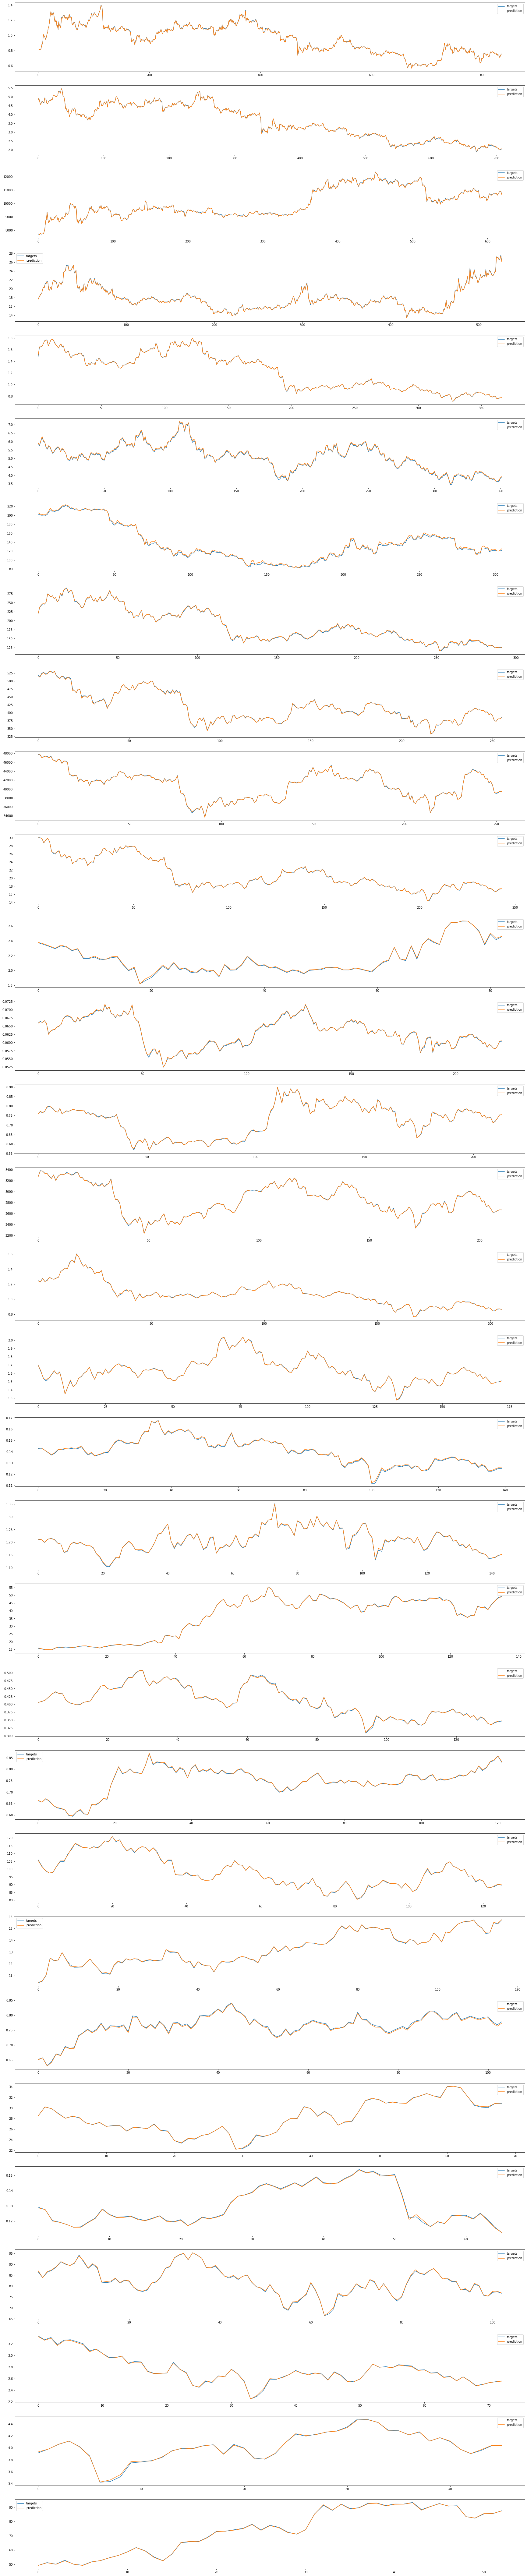

In [63]:
fig, axs = plt.subplots(len(dm.test_datasets), figsize=(30, 5 * len(dm.test_datasets)))
tf.config.run_functions_eagerly(True)
for index, (scaler, klines, single_closes) in enumerate(dm.test_datasets):
    predictions = reg.predict(tf.squeeze(klines))
    predictions = scaler.inverse_transform(predictions.reshape(-1, 1))
    targets = scaler.inverse_transform(tf.reshape(single_closes, shape=(-1, 1)))
    axs[index].plot(targets[:-1], label="targets")
    axs[index].plot(predictions[1:], label="prediction")
    axs[index].legend()


In [ ]:
run.finish()


close_generator,█▁
d_loss,█▁
direction_accuracy,█▁
epoch,▁█
fake_discriminator,█▁
fake_generator,█▁
g_loss,█▁
penalty_discriminator,█▁
real_discriminator,█▁
close_generator,0.29337
d_loss,0.90561
